# Homework 4

## FINM 35700 - Spring 2024

### UChicago Financial Mathematics

### Due Date: 2025-04-22

* Matheus Raka Pradnyatama
* matheusraka@uchicago.edu

This homework relies on:

Interest Rate & Credit Default Swaps
- the SOFR OIS symbology file `sofr_swap_symbology`,
- the SOFR swaps market data file `sofr_swaps_market_data_eod`,
- the CDS spreads market data file `cds_market_data_eod`.

HYG ETF corporate bonds:
- the HYG bond symbology file `hyg_bond_symbology` and
- the HYG basket composition file (containing bond weights and yields) `hyg_basket_composition`.

In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import QuantLib as ql
import datetime as dt
from scipy.optimize import fsolve
from scipy.optimize import root_scalar

# The code is made with the help of OpenAI's ChatGPT.

# import tools from previous homeworks
from credit_market_tools import *

# Use static calculation/valuation date of 2024-12-13, matching data available in the market prices EOD file
calc_date = ql.Date(13, 12, 2024)
ql.Settings.instance().evaluationDate = calc_date

# Calculation/valuation date as pd datetime
as_of_date = pd.to_datetime('2024-12-13')

-----------------------------------------------------------
# Problem 1: Fixed rate bond prices and sensitivities (bond yield model)

## When computing sensitivities, assume "everything else being equal" (ceteris paribus).

For a better understanding of dependencies, you can use the simple fixed rate bond valuation formula in the flat yield model (formula [6] in Lecture 1).

\begin{align}
PV_{Bond}\left(c,T,y_{sa} \right)=1+\frac{c-y_{sa}}{y_{sa}}\cdot\left[1-\left(1+\frac{y_{sa}}{2}\right)^{-2T}\right]
\end{align}


## a. True or False (fixed rate bond prices)

1. Fixed rate bond price is increasing in yield.
2. Fixed rate bond price is increasing in coupon
3. Fixed rate bond price is increasing in bond maturity
4. Fixed rate callable bond prices are higher or equal to their "bullet" (non-callable) version.

Answer:
1. <b> FALSE. </b> As yield increases, the price for a fixed-rate bond decreases. 

2. <b> TRUE. </b> As coupon increases, the price for a fixed-rate bond increases. Investors receive higher interest payments and a larger proportion of the bond's total value in the earlier periods. 

3. <b> FALSE. </b> As maturity increases, the price for a fixed-rate bond decreases. Higher maturity --> higher uncertainty --> price decrease.

4. <b> FALSE. </b> A callable bond allows the issuer to call the bond earlier, causing a reduction in the investor's payoff. Callable bond price should be lower or equal to its non-call version.

## b. True or False (fixed rate bond yields)

1. Fixed rate bond yield is increasing in interest rate (assuming credit spread unchanged)    
2. Fixed rate bond yield is increasing in credit spread (assuming interest rate unchanged)    
3. Fixed rate bond yield is increasing in coupon
4. Fixed rate bond yield is increasing in bond maturity (assume term structure of yield curve is known)


Answer:
1. As interest rate increase, investors should buy newly-issued bonds compared to those issued in previous periods when interest rate was low. Price of a fixed-rate bond goes down, yield of a fixed-rate bond goes up. The statement is TRUE.

2. Credit spread is the spread between yields on risky bonds vs risk-free rate. If interest rates were unchanged, and the spread increase, it means the yield on risky bonds increase. Fixed-rate bond yield will increase. The statement is TRUE.

3. As coupon rate increases, price of a fixed-rate bond increase. Thus, the yield of the fixed-rate bond decrease (inverse relationship). The statement is FALSE.

4. FALSE. Yield-maturity relationship depends on the shape of the yield curve. <br>
Normal yield curve: Maturity goes up, yields go up. <br>
Inverted yield curve: Maturity goes up, yields go down.

## c. True or False (fixed rate bond durations)

1. Fixed rate bond duration is increasing with yield
2. Fixed rate bond duration is increasing in coupon
3. Fixed rate bond duration is increasing with bond maturity
4. Fixed rate callable bond durations are higher or equal to their "bullet" (non-callable) version.


Duration is the sum of the weighted TTM of the cash flow of the instrument. Duration also represents how long the investor is going to receive the present value of the instrument from the instrument's cash flows.

1. An increase in yield --> future cash flows are discounted more heavily --> there's less weight for future cash flows --> lower weighted sum of the cash flows --> lower duration. Statement is FALSE.

2. An increase in coupon --> investor can receive the present value faster  --> lower duration. The statement is FALSE.

3. An increase in maturity --> takes longer for the investor to receive the present value --> higher duration. The statement is TRUE.

4. A callable bond can be called earlier than the maturity date. The realized maturity can be shorter than the original maturity. Lower maturity --> lower duration. A fixed-rate callable bond's duration is lower or equal to their "bullet" (non-callable) version. This statement is FALSE.

## d. True or False (fixed rate bond convexities)

1. Fixed rate bond convexity is increasing with yield
2. Fixed rate bond convexity is increasing in coupon
3. Fixed rate bond convexity is increasing with bond maturity
4. Fixed rate callable bond convexities are higher or equal to their "bullet" (non-callable) version.


Higher sensitivity to yield changes --> higher duration and higher convexity.

1. An increase in yield --> future cash flows are discounter more heavily --> less weight on future cash flows --> bond becomes less sensitive to yield changes --> lower duration and lower convexity. The statement is FALSE.

2. Lower coupon --> most of the bond's value is recoup at later cash flows --> bond becomes highly sensitive to yield changes --> higher duration & convexity. <br>
Higher coupon --> most of the bond's value is recoup in earlier cash flows --> bond becomes less sensitive to yield changes --> lower duration & convexity. <br>
The statement is FALSE.

3. Convexity is the weighted sum of cashflow TTM squared. <br>
An increase in maturity --> takes longer for the investor to receive the present value --> bond becomes highly sensitive to yield changes --> higher duration & convexity. The statement is TRUE.

4. A callable bond can have a negative convexity. 

During periods of falling interest rates, a bullet bond (which has a positive convexity) is expected to have its price to rise. 
However, for a callable bond, during this period, there is a greater likelihood that issuers will call their bonds. Therefore, callable bond prices might actually go down instead of up. This is why a callable bond can have a negative convexity (rates and price fall together). 

Fixed-rate callable bond's convexity is lower or equal to their 'bullet' version. The statement is FALSE.

-----------------------------------------------------------
# Problem 2: US SOFR swap curve calibration as of 2024-12-13
### Follow Section "1. SOFR OIS swap rates and SOFR discount curve calibration + validation" in the QuantLib Advanced notebook !

## a. Load and explore US SOFR swaps symbology and market data

Load the `sofr_swap_symbology` Excel file into a dataframe. Print all swap tenors available.

Load the `sofr_swaps_market_data_eod` Excel file into a dataframe. Print all dates available.

Plot the historial time series of SOFR rates for the available [1Y, 2Y, 3Y, 5Y, 7Y, 10Y, 20Y, 30Y] tenors.

In [2]:
# sofr_swaps_symbology Dataframe

filepath_rawdata = f'./data/sofr_swaps_symbology.xlsx'
sofr_swaps_symbology = pd.read_excel(filepath_rawdata)

display(sofr_swaps_symbology)

,figi,ticker,class,bbg,name,tenor,type,dcc,exchange,country,currency,status
0,BBG00KFWPJJ9,USOSFR1,Curncy,USOSFR1 Curncy,USD OIS ANN VS SOFR 1Y,1,SWAP,ACT/360,NONE,US,USD,ACTV
1,BBG00KFWPJX3,USOSFR2,Curncy,USOSFR2 Curncy,USD OIS ANN VS SOFR 2Y,2,SWAP,ACT/360,NONE,US,USD,ACTV
2,BBG00KFWPK15,USOSFR3,Curncy,USOSFR3 Curncy,USD OIS ANN VS SOFR 3Y,3,SWAP,ACT/360,NONE,US,USD,ACTV
3,BBG00KFWPK51,USOSFR5,Curncy,USOSFR5 Curncy,USD OIS ANN VS SOFR 5Y,5,SWAP,ACT/360,NONE,US,USD,ACTV
4,BBG00KFWPK79,USOSFR7,Curncy,USOSFR7 Curncy,USD OIS ANN VS SOFR 7Y,7,SWAP,ACT/360,NONE,US,USD,ACTV
5,BBG00KFWPKB4,USOSFR10,Curncy,USOSFR10 Curncy,USD OIS ANN VS SOFR 10Y,10,SWAP,ACT/360,NONE,US,USD,ACTV
6,BBG00KFWPKF0,USOSFR20,Curncy,USOSFR20 Curncy,USD OIS ANN VS SOFR 20Y,20,SWAP,ACT/360,NONE,US,USD,ACTV
7,BBG00KFWPKH8,USOSFR30,Curncy,USOSFR30 Curncy,USD OIS ANN VS SOFR 30Y,30,SWAP,ACT/360,NONE,US,USD,ACTV


In [3]:
# sofr_swaps_market_data_eod Dataframe

filepath_rawdata = f'./data/sofr_swaps_market_data_eod.xlsx'
sofr_swaps_market_data_eod = pd.read_excel(filepath_rawdata)

# All dates
display(sofr_swaps_market_data_eod)

,date,figi,bidRate,askRate,midRate
0,2024-01-02,BBG00KFWPJJ9,4.7960,4.8046,4.80030
1,2024-01-02,BBG00KFWPJX3,4.1368,4.1452,4.14100
2,2024-01-02,BBG00KFWPK15,3.8258,3.8327,3.82925
3,2024-01-02,BBG00KFWPK51,3.5907,3.5943,3.59250
4,2024-01-02,BBG00KFWPK79,3.5297,3.5333,3.53150
...,...,...,...,...,...
1874,2024-12-13,BBG00KFWPK51,3.9133,3.9181,3.91570
1875,2024-12-13,BBG00KFWPK79,3.8937,3.8991,3.89640
1876,2024-12-13,BBG00KFWPKB4,3.9015,3.9065,3.90400
1877,2024-12-13,BBG00KFWPKH8,3.7602,3.7662,3.76320


In [4]:
# Merge Data to give Tenor
merged_sofr = pd.merge(sofr_swaps_symbology, sofr_swaps_market_data_eod, on=['figi'], how='inner')
display(merged_sofr[['date', 'figi', 'ticker', 'tenor', 'midRate','dcc']])

,date,figi,ticker,tenor,midRate,dcc
0,2024-01-02,BBG00KFWPJJ9,USOSFR1,1,4.80030,ACT/360
1,2024-01-03,BBG00KFWPJJ9,USOSFR1,1,4.83170,ACT/360
2,2024-01-04,BBG00KFWPJJ9,USOSFR1,1,4.86400,ACT/360
3,2024-01-05,BBG00KFWPJJ9,USOSFR1,1,4.84020,ACT/360
4,2024-01-08,BBG00KFWPJJ9,USOSFR1,1,4.84690,ACT/360
...,...,...,...,...,...,...
1874,2024-12-09,BBG00KFWPKH8,USOSFR30,30,3.57900,ACT/360
1875,2024-12-10,BBG00KFWPKH8,USOSFR30,30,3.60195,ACT/360
1876,2024-12-11,BBG00KFWPKH8,USOSFR30,30,3.65820,ACT/360
1877,2024-12-12,BBG00KFWPKH8,USOSFR30,30,3.71760,ACT/360


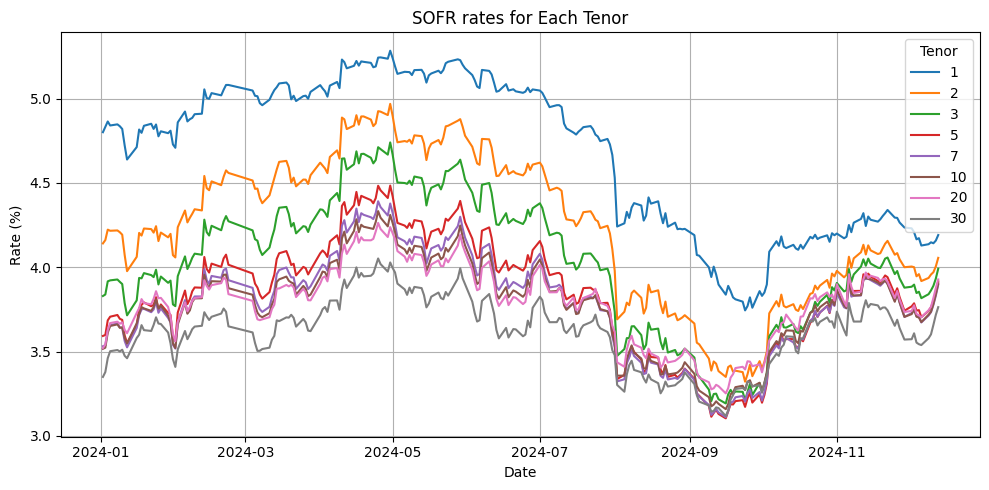

In [5]:
plt.figure(figsize=(10, 5))

# Loop over each group
# variable: the unique value of the group
# group: the subset DataFrame of rows that belong to that group
for tenor, group in merged_sofr.groupby('tenor'):
    plt.plot(group['date'], group['midRate'], label=tenor)

# Labels and title
plt.xlabel("Date")
plt.ylabel("Rate (%)")
plt.title("SOFR rates for Each Tenor")
plt.legend(title='Tenor')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

## b. Calibrate the US SOFR yield curve (via bootstrapping)
The function below shows how to calibrate a smooth yield/discount factor curve from SOFR swaps. 

Prepare a joint symbology & market dataframe quotes as of 2024-12-13. 

Calibrate the SOFR discount factor curve as of 2024-12-13.

Follow section 1b in the QuantLib Advanced notebook.

In [6]:
def calibrate_sofr_curve_from_frame(
        calc_date: ql.Date,
        sofr_details: pd.DataFrame,
        rate_quote_column: str):
    '''Create a calibrated yield curve from a SOFR details dataframe which includes rate quotes.
    '''
    ql.Settings.instance().evaluationDate = calc_date

    # Sort dataframe by maturity
    sorted_details_frame = sofr_details.sort_values(by='tenor')    
    
    # settle_days
    settle_days = 1
    
    # For US SOFR OIS Swaps 
    day_count = ql.Actual360()

    # For US SOFR Swaps     
    calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
    
    sofr_helpers = []
    
    for index, row in sorted_details_frame.iterrows():
        sofr_quote = row[rate_quote_column]
        tenor_in_years = row['tenor']
        sofr_tenor = ql.Period(tenor_in_years, ql.Years)
        
        # create sofr_rate_helper
        sofr_helper = ql.OISRateHelper(settle_days, sofr_tenor, ql.QuoteHandle(ql.SimpleQuote(sofr_quote/100)), ql.Sofr())
                        
        sofr_helpers.append(sofr_helper)
        
    sofr_yield_curve = ql.PiecewiseLinearZero(settle_days, calendar, sofr_helpers, day_count)
    sofr_yield_curve.enableExtrapolation()
    
    return sofr_yield_curve

In [7]:
# Include only data from the as_of_date
merged_sofr_current = merged_sofr[merged_sofr['date'] == as_of_date]
display(merged_sofr_current[['date', 'figi', 'ticker', 'tenor', 'midRate','dcc']])

,date,figi,ticker,tenor,midRate,dcc
234,2024-12-13,BBG00KFWPJJ9,USOSFR1,1,4.19080,ACT/360
469,2024-12-13,BBG00KFWPJX3,USOSFR2,2,4.05545,ACT/360
704,2024-12-13,BBG00KFWPK15,USOSFR3,3,3.99135,ACT/360
939,2024-12-13,BBG00KFWPK51,USOSFR5,5,3.91570,ACT/360
1174,2024-12-13,BBG00KFWPK79,USOSFR7,7,3.89640,ACT/360
1409,2024-12-13,BBG00KFWPKB4,USOSFR10,10,3.90400,ACT/360
1643,2024-12-13,BBG00KFWPKF0,USOSFR20,20,3.92750,ACT/360
1878,2024-12-13,BBG00KFWPKH8,USOSFR30,30,3.76320,ACT/360


In [8]:
# Calibrating the Yield Curve
calc_date = calc_date
sofr_details =  merged_sofr_current
rate_quote_column = 'midRate' # Name of the Rate column

# Create SOFR Yield Curve
sofr_yield_curve = calibrate_sofr_curve_from_frame(calc_date, sofr_details, rate_quote_column)
print(sofr_yield_curve)

<QuantLib.QuantLib.PiecewiseLinearZero; proxy of <Swig Object of type 'ext::shared_ptr< PiecewiseLinearZero > *' at 0x142135300> >


## c. Display the calibrated SOFR discount curve dataframe

Follow section 1d (in the QuantLib Advanced notebook) to display the calibration details dataframe.

In [9]:
def get_yield_curve_details_df(yield_curve, curve_dates=None):
    
    if(curve_dates == None):
        curve_dates = yield_curve.dates()

    dates = [d.to_date() for d in curve_dates]
    discounts = [round(yield_curve.discount(d), 3) for d in curve_dates]
    yearfracs = [round(yield_curve.timeFromReference(d), 3) for d in curve_dates]
    zeroRates = [round(yield_curve.zeroRate(d, yield_curve.dayCounter(), ql.Compounded).rate() * 100, 3) for d in curve_dates]

    yield_curve_details_df = pd.DataFrame(data={'Date': dates,
                             'YearFrac': yearfracs,
                             'DiscountFactor': discounts,
                             'ZeroRate': zeroRates})                             
    return yield_curve_details_df

# Display SOFR yield curve
grid_dates = [sofr_yield_curve.referenceDate() + ql.Period(y, ql.Years) for y in list(range(0,30,1))]

sofr_yield_curve_simple_df = get_yield_curve_details_df(sofr_yield_curve)                  # using calibration grid
sofr_yield_curve_details_df = get_yield_curve_details_df(sofr_yield_curve, grid_dates)    # using external grid

display(sofr_yield_curve_simple_df)
display(sofr_yield_curve_details_df)


,Date,YearFrac,DiscountFactor,ZeroRate
0,2024-12-16,0.000,1.000,4.190
1,2025-12-16,1.014,0.959,4.190
2,2026-12-16,2.028,0.923,4.052
3,2027-12-16,3.042,0.888,3.986
4,2029-12-17,5.075,0.823,3.907
5,2031-12-16,7.100,0.763,3.888
6,2034-12-18,10.150,0.678,3.899
7,2044-12-16,20.292,0.457,3.931
8,2054-12-16,30.436,0.333,3.676


,Date,YearFrac,DiscountFactor,ZeroRate
0,2024-12-16,0.000,1.000,4.190
1,2025-12-16,1.014,0.959,4.190
2,2026-12-16,2.028,0.923,4.052
3,2027-12-16,3.042,0.888,3.986
4,2028-12-16,4.058,0.855,3.946
5,2029-12-16,5.072,0.823,3.907
6,2030-12-16,6.086,0.792,3.897
7,2031-12-16,7.100,0.763,3.888
8,2032-12-16,8.117,0.734,3.892
9,2033-12-16,9.131,0.705,3.895


## d. Plot the calibrated US SOFR Zero Interest Rates and Discount Factor curves

Plot the SOFR zero rates and discount factor curves by maturity. Follow section 1c in the QuantLib Advanced notebook.

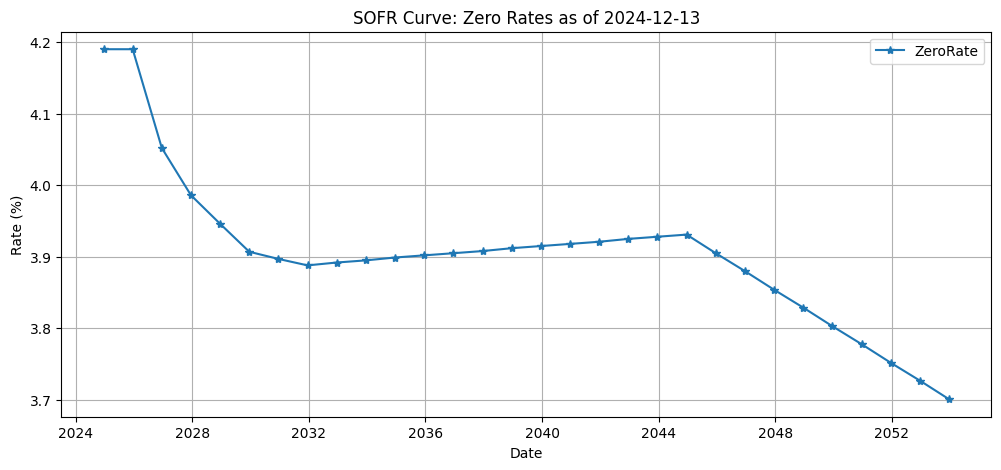

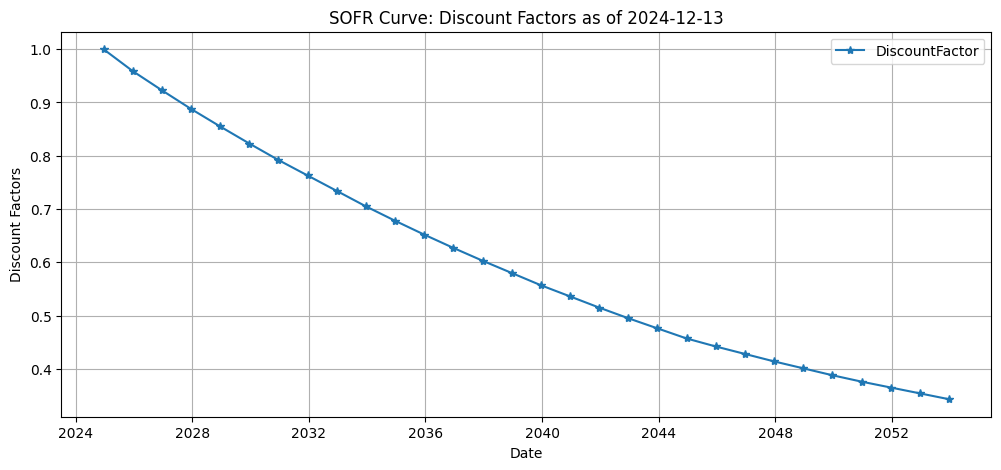

In [10]:
plt.figure(figsize=(12, 5))
plt.plot(sofr_yield_curve_details_df['Date'], sofr_yield_curve_details_df['ZeroRate'], '*-', label='ZeroRate')
plt.title(f'SOFR Curve: Zero Rates as of {calc_date.to_date()}')
plt.xlabel('Date')
plt.ylabel('Rate (%)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(sofr_yield_curve_details_df['Date'], sofr_yield_curve_details_df['DiscountFactor'], '*-', label='DiscountFactor')
plt.title(f'SOFR Curve: Discount Factors as of {calc_date.to_date()}')
plt.xlabel('Date')
plt.ylabel('Discount Factors')
plt.legend()
plt.grid()
plt.show()

-----------------------------------------------------------
# Problem 3: CDS Hazard Rate calibration and valuation
## Follow Section "2. CDS Hazard Rate calibration + Pricing" in the QuantLib Advanced notebook !!!

## a. Load and explore the CDS market data (IBM credit issuer)

Load the `cds_market_data_eod` Excel file into a dataframe. 

Plot the historical time series of CDS Par Spreads for the available tenors.


In [11]:
# sofr_swaps_market_data_eod Dataframe

filepath_rawdata = f'./data/cds_market_data_eod.xlsx'
cds_market_data_eod = pd.read_excel(filepath_rawdata)

display(cds_market_data_eod)

,date,ticker,short_name,tier,sector,region,currency,doc_clause,running_coupon,cds_assumed_recovery,par_spread_1y,par_spread_2y,par_spread_3y,par_spread_5y,par_spread_7y,par_spread_10y
0,2024-01-02,IBM,Intl Business Machs Corp,SNRFOR,Technology,N.Amer,USD,XR14,0.01,0.4,13.6831,18.8194,28.3917,44.7053,62.1494,69.1972
1,2024-01-03,IBM,Intl Business Machs Corp,SNRFOR,Technology,N.Amer,USD,XR14,0.01,0.4,14.2256,19.6610,29.4493,46.4866,63.6475,71.4311
2,2024-01-04,IBM,Intl Business Machs Corp,SNRFOR,Technology,N.Amer,USD,XR14,0.01,0.4,13.8318,19.1828,28.8454,45.4735,62.6543,70.9180
3,2024-01-05,IBM,Intl Business Machs Corp,SNRFOR,Technology,N.Amer,USD,XR14,0.01,0.4,13.6181,18.7703,28.3417,44.7575,61.9778,70.2746
4,2024-01-08,IBM,Intl Business Machs Corp,SNRFOR,Technology,N.Amer,USD,XR14,0.01,0.4,13.4433,18.3692,27.7599,43.8548,60.8378,68.8914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,2024-12-09,IBM,Intl Business Machs Corp,SNRFOR,Technology,N.Amer,USD,XR14,0.01,0.4,10.8295,17.3846,23.4847,36.4824,51.4723,60.1364
235,2024-12-10,IBM,Intl Business Machs Corp,SNRFOR,Technology,N.Amer,USD,XR14,0.01,0.4,10.8596,17.4253,23.3863,36.4596,51.4087,59.7699
236,2024-12-11,IBM,Intl Business Machs Corp,SNRFOR,Technology,N.Amer,USD,XR14,0.01,0.4,10.7307,16.9474,23.0922,36.2081,51.6831,60.0279
237,2024-12-12,IBM,Intl Business Machs Corp,SNRFOR,Technology,N.Amer,USD,XR14,0.01,0.4,10.9981,15.7821,22.5616,35.6660,51.0343,62.3046


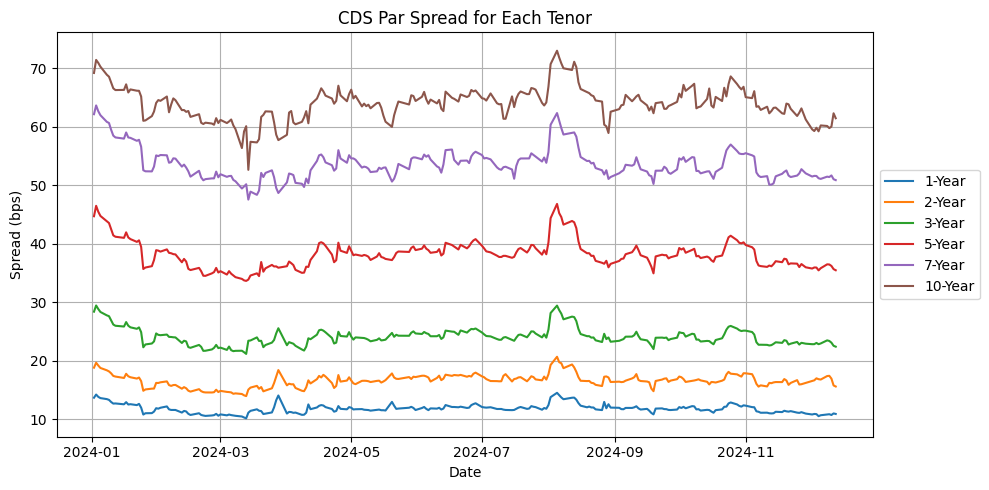

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(cds_market_data_eod['date'], cds_market_data_eod['par_spread_1y'], '-', label='1-Year')
plt.plot(cds_market_data_eod['date'], cds_market_data_eod['par_spread_2y'], '-', label='2-Year')
plt.plot(cds_market_data_eod['date'], cds_market_data_eod['par_spread_3y'], '-', label='3-Year')
plt.plot(cds_market_data_eod['date'], cds_market_data_eod['par_spread_5y'], '-', label='5-Year')
plt.plot(cds_market_data_eod['date'], cds_market_data_eod['par_spread_7y'], '-', label='7-Year')
plt.plot(cds_market_data_eod['date'], cds_market_data_eod['par_spread_10y'], '-', label='10-Year')

plt.title('CDS Par Spread for Each Tenor')
plt.xlabel('Date')
plt.ylabel('Spread (bps)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()  # Adjust plot to fit within figure area
plt.grid()
plt.show()

## b. Calibrate the IBM hazard rate curve as of 2024-12-13

Follow section 2a in the QuantLib Advanced notebook. Use the calibrated SOFR discount curve from Problem 2b.

In [13]:
cds_market_data_eod_current = cds_market_data_eod[cds_market_data_eod['date'] == as_of_date]
par_spread_df = cds_market_data_eod_current[['date',
                                            'par_spread_1y', 
                                             'par_spread_2y', 
                                             'par_spread_3y', 
                                             'par_spread_5y', 
                                             'par_spread_7y', 
                                             'par_spread_10y', 
                                             ]]
# Par Spread as of as_of_date
display(par_spread_df)

# Get the values as list
par_spread_list = par_spread_df.iloc[-1][1:].tolist()
print(par_spread_list)

,date,par_spread_1y,par_spread_2y,par_spread_3y,par_spread_5y,par_spread_7y,par_spread_10y
238,2024-12-13,10.9082,15.6009,22.4095,35.4733,50.8816,61.462


[np.float64(10.9082), np.float64(15.6009), np.float64(22.4095), np.float64(35.4733), np.float64(50.8816), np.float64(61.462)]


In [14]:
# settle_days
settle_days = 1

# Yield Curve Handle
sofr_yield_curve_handle = ql.YieldTermStructureHandle(sofr_yield_curve)

CDS_recovery_rate = 0.4

CDS_day_count = ql.Actual360()

# CDS standard tenors: 1Y, 2Y, 3Y, 5Y 7Y and 10Y
CDS_tenors = [ql.Period(y, ql.Years) for y in [1, 2, 3, 5, 7, 10]]
              
# CDS spreads for IBM as of calc_date = 2024-12-13
CDS_spreads = par_spread_list # In bps

CDS_helpers = [ql.SpreadCdsHelper((CDS_spread / 10_000.0), CDS_tenor, settle_days, ql.TARGET(),
                ql.Quarterly, ql.Following, ql.DateGeneration.TwentiethIMM, CDS_day_count, CDS_recovery_rate, sofr_yield_curve_handle)               
                for (CDS_spread, CDS_tenor) in zip(CDS_spreads, CDS_tenors)]

# bootstrap hazard_rate_curve
hazard_rate_curve = ql.PiecewiseFlatHazardRate(calc_date, CDS_helpers, CDS_day_count)
hazard_rate_curve.enableExtrapolation()

# Display calibrated hazard rates and survival probabilities
hazard_list = [(hr[0].to_date(), 
                CDS_day_count.yearFraction(calc_date, hr[0]),
                hr[1] * 100,
                hazard_rate_curve.survivalProbability(hr[0]))   # Survival Prob
                # 1-hazard_rate_curve.survivalProbability(hr[0])) # Default Prob
                for hr in hazard_rate_curve.nodes()]

grid_dates, year_frac, hazard_rates, surv_probs = zip(*hazard_list)

hazard_rates_df = pd.DataFrame(data={'Date': grid_dates, 
                                     'YearFrac': year_frac,
                                     'HazardRate': hazard_rates,
                                     'SurvivalProb': surv_probs})
display(hazard_rates_df)


,Date,YearFrac,HazardRate,SurvivalProb
0,2024-12-13,0.000000,0.179862,1.000000
1,2025-12-22,1.038889,0.179862,0.998133
2,2026-12-21,2.050000,0.341810,0.994690
3,2027-12-20,3.061111,0.614840,0.988525
4,2029-12-20,5.091667,0.953377,0.969572
5,2031-12-22,7.125000,1.604396,0.938453
6,2034-12-20,10.163889,1.551602,0.895230


## c. Plot the calibrated Hazard Rates and Survival Probability curves
Follow section 2b in the QuantLib Advanced notebook. Use the calibrated SOFR discount curve from Problem 2b.

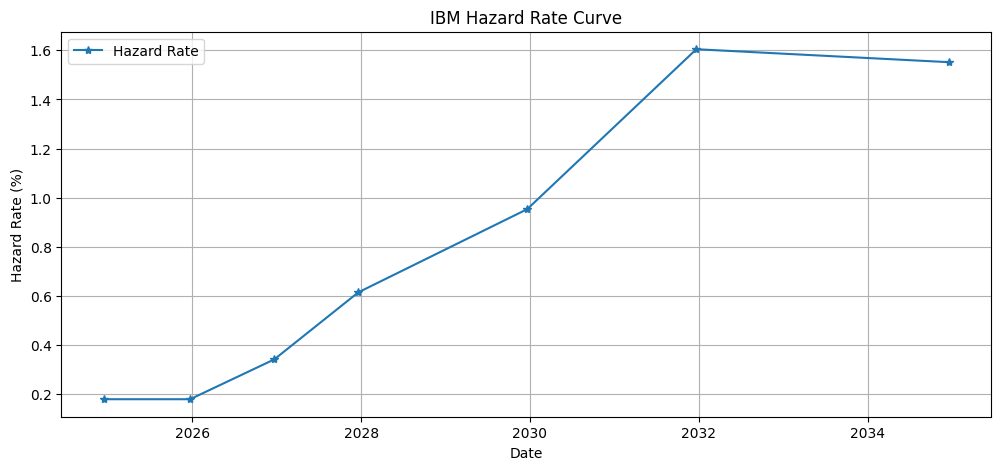

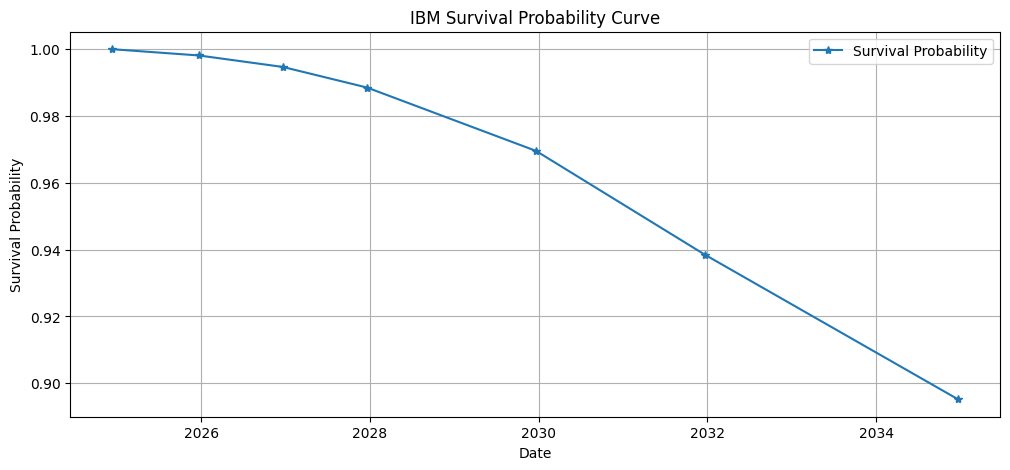

In [15]:
plt.figure(figsize=(12, 5))
plt.plot(hazard_rates_df['Date'], hazard_rates_df['HazardRate'], '*-', label='Hazard Rate')
plt.title('IBM Hazard Rate Curve')
plt.xlabel('Date')
plt.ylabel('Hazard Rate (%)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(hazard_rates_df['Date'], hazard_rates_df['SurvivalProb'], '*-', label='Survival Probability')
plt.title('IBM Survival Probability Curve')
plt.xlabel('Date')
plt.ylabel('Survival Probability')
plt.legend()
plt.grid()
plt.show()

## d. Compute the fair/par spread and PV of a 5 year CDS contract

Follow section 2c in the QuantLib Advanced notebook. Construct a CDS object with 100 bps coupon and 2029-06-20 maturity. Compute the fair/par spread and PV.


In [16]:
# CDS specs
side = ql.Protection.Seller

face_notional = 100

contractual_spread = 100 / 10_000 # Coupon on CDS 

cds_start_date = ql.Date(13, 12, 2024)
cds_maturity_date = ql.Date(20, 6, 2029)

# Create CDS schedule
cds_schedule = ql.MakeSchedule(cds_start_date, cds_maturity_date, ql.Period('3M'),
                            ql.Quarterly, ql.TARGET(), ql.Following, ql.Unadjusted, ql.DateGeneration.TwentiethIMM)

# display(list(cds_schedule))

# Create CDS object
cds_obj = ql.CreditDefaultSwap(side, face_notional, contractual_spread, cds_schedule, ql.Following, ql.Actual360())

# Create CDS Implied Credit Curve and pricing engine
cds_surv_prob_curve_handle = ql.DefaultProbabilityTermStructureHandle(hazard_rate_curve)

cds_pricing_engine = ql.MidPointCdsEngine(cds_surv_prob_curve_handle, CDS_recovery_rate, sofr_yield_curve_handle)
cds_obj.setPricingEngine(cds_pricing_engine)

# Print CDS valuation results
print('CDS protection start date:', cds_obj.protectionStartDate())
print('CDS fair/par spread (bps):', round(cds_obj.fairSpread()*10_000, 3))
print('CDS PV:', round(cds_obj.NPV(), 4))    
print('CDS Premium Leg PV:', round(cds_obj.couponLegNPV(), 4))
print('CDS Default Leg PV:', round(cds_obj.defaultLegNPV(), 4))
print('Survival Prob. to Maturity:', round(hazard_rate_curve.survivalProbability(cds_maturity_date), 4))

CDS protection start date: December 13th, 2024
CDS fair/par spread (bps): 33.238
CDS PV: 2.7634
CDS Premium Leg PV: 4.1391
CDS Default Leg PV: -1.3758
Survival Prob. to Maturity: 0.9743


-----------------------------------------------------------
# Problem 4: Credit ETF analysis on HYG (iShares High Yield Corporate Bond ETF)

## a. Load and explore the HYG basket composition and market data

Load the `hyg_basket_composition` Excel file into a dataframe. It contains the HYG basket constituent face notionals, weights and yields-to-maturities as of 2024-12-13.

Load the `hyg_corp_symbology` Excel file into a dataframe. It contains the corporate bond details for HYG constituents.

How many corporate bonds are in the HYG basket?  What are the average and median face notionals for a bond?

How many unique tickers are in the HYG basket? What are the average and median face notionals for a ticker?

Compute mean, median and standard deviation of yields-to-maturity of bonds in the basket.

In [17]:
# hyg_basket_composition Dataframe
filepath_rawdata = f'./data/hyg_basket_composition.xlsx'
hyg_basket_composition = pd.read_excel(filepath_rawdata)
display(hyg_basket_composition.head(3))

# hyg_corp_symbology Dataframe
filepath_rawdata = f'./data/hyg_corp_symbology.xlsx'
hyg_corp_symbology = pd.read_excel(filepath_rawdata)
display(hyg_corp_symbology.head(3))

,date,etf_ticker,figi,isin,security,description,coupon,maturity,cpn_type,class,currency,bidYield,askYield,midYield,face_notional,face_notional_weight
0,2024-12-13,HYG,BBG00Z3K0YS9,US00489LAF04,ACRISU 4 1/4 02/15/29,ACRISURE LLC 4.25 02/15/2029 144a (SECURED),4.250,2029-02-15,FIXED,Corp,USD,5.674,5.439,5.5565,9750000,0.062760
1,2024-12-13,HYG,BBG011Y6QG29,US00489LAH69,ACRISU 6 08/01/29,ACRISURE LLC 6.0 08/01/2029 144a (SENIOR),6.000,2029-08-01,FIXED,Corp,USD,6.790,6.578,6.6840,7152000,0.046038
2,2024-12-13,HYG,BBG00DHXNL44,US00687YAA38,ADNT 4 7/8 08/15/26,ADIENT GLOBAL HOLDINGS LTD 4.875 08/15/2026 14...,4.875,2026-08-15,FIXED,Corp,USD,5.837,5.520,5.6785,10453000,0.067283


,ticker,class,figi,isin,und_bench_isin,security,name,type,coupon,cpn_type,...,start_date,cpn_first,acc_first,maturity,mty_typ,rank,amt_out,country,currency,status
0,AA,Corp,BBG00VYJS3B3,US013822AE11,US91282CMB45,AA 5 1/2 12/15/27,ALCOA NEDERLAND HOLDING,PRIV PLACEMENT,5.500,FIXED,...,2020-07-13,2020-12-15,2020-07-13,2027-12-15,CALLABLE,Sr Unsecured,750.0,NE,USD,ACTV
1,AA,Corp,BBG00KXCGK19,US013822AC54,US91282CLY56,AA 6 1/8 05/15/28,ALCOA NEDERLAND HOLDING,PRIV PLACEMENT,6.125,FIXED,...,2018-05-17,2018-11-15,2018-05-17,2028-05-15,CALLABLE,Sr Unsecured,500.0,NE,USD,ACTV
2,AA,Corp,BBG00ZKWG886,US013822AG68,US91282CMA61,AA 4 1/8 03/31/29,ALCOA NEDERLAND HOLDING,PRIV PLACEMENT,4.125,FIXED,...,2021-03-24,2021-09-30,2021-03-24,2029-03-31,CALLABLE,Sr Unsecured,500.0,NE,USD,ACTV


In [18]:
# Merge Data 
merged_hyg = pd.merge(hyg_basket_composition, hyg_corp_symbology, on=['figi', 'isin', 'security', 'coupon', 
                                                                      'cpn_type', 'maturity', 'class', 'currency'], how='inner')
display(merged_hyg[['date', 'ticker', 'figi', 'isin', 'face_notional', 'midYield']])

,date,ticker,figi,isin,face_notional,midYield
0,2024-12-13,ACRISU,BBG00Z3K0YS9,US00489LAF04,9750000,5.5565
1,2024-12-13,ACRISU,BBG011Y6QG29,US00489LAH69,7152000,6.6840
2,2024-12-13,ADNT,BBG00DHXNL44,US00687YAA38,10453000,5.6785
3,2024-12-13,ADNT,BBG01FP4YJ64,US00687YAC93,8773000,6.7715
4,2024-12-13,AETUNI,BBG01PXHHPM1,US00810GAD60,17028000,6.4870
...,...,...,...,...,...,...
1188,2024-12-13,VENTGL,BBG011Y6HG38,US92328MAB90,18802000,5.8045
1189,2024-12-13,VMED,BBG00V6PPMN8,US92769VAJ89,14373000,8.1470
1190,2024-12-13,VSTJET,BBG016XSPMY4,US92840JAD19,7860000,8.7870
1191,2024-12-13,WDC,BBG00JXGN2L3,US958102AM75,31766000,5.5315


In [19]:
# A bond in the HYG Basket

display(merged_hyg[['face_notional']].describe())

face_notional_count = merged_hyg['face_notional'].count()
face_notional_mean = merged_hyg['face_notional'].mean()
face_notional_median = merged_hyg['face_notional'].median()

print(f"Number of Corporate Bonds in the HYG Basket: {face_notional_count:,.0f}")
print(f"Average of Face Notional for a Bond: {face_notional_mean:,.0f}")
print(f"Median of Face Notional for a Bond: {face_notional_median:,.0f}")

,face_notional
count,1.193000e+03
mean,1.319556e+07
std,8.131959e+06
min,0.000000e+00
25%,8.086000e+06
50%,1.126700e+07
75%,1.559900e+07
max,6.865500e+07


Number of Corporate Bonds in the HYG Basket: 1,193
Average of Face Notional for a Bond: 13,195,565
Median of Face Notional for a Bond: 11,267,000


In [20]:
# Group by ticker, take the sum of notional per ticker
ticker_df = merged_hyg[['face_notional', 'ticker']].groupby(['ticker']).sum()
ticker_df.columns = ['face_notional_sum'] 
display(ticker_df.head())
display(ticker_df.tail())

,face_notional_sum
ticker,
AA,31698000
AAL,27647000
AAP,8373000
ABCSUP,15271000
ABG,34743000


,face_notional_sum
ticker,
XRX,20324000
YUM,70371000
ZAYO,41141000
ZFFNGR,42556000
ZIGGO,56785000


In [22]:
# A ticker in the HYG Basket

display(ticker_df.describe())

face_notional_count = ticker_df['face_notional_sum'].count()
face_notional_mean = ticker_df['face_notional_sum'].mean()
face_notional_median = ticker_df['face_notional_sum'].median()

print(f"Number of Unique Corporate Tickers in the HYG Basket: {face_notional_count:,.0f}")
print(f"Average of Face Notional for a Ticker: {face_notional_mean:,.0f}")
print(f"Median of Face Notional for a Ticker: {face_notional_median:,.0f}")

,face_notional_sum
count,4.150000e+02
mean,3.793327e+07
std,3.668634e+07
min,1.100000e+04
25%,1.863500e+07
50%,2.660600e+07
75%,4.260550e+07
max,4.071200e+08


Number of Unique Corporate Tickers in the HYG Basket: 415
Average of Face Notional for a Ticker: 37,933,275
Median of Face Notional for a Ticker: 26,606,000


In [ ]:
# A bond in the HYG Basket

display(merged_hyg[['midYield']].describe())

ytm_mean = merged_hyg['midYield'].mean()
ytm_median = merged_hyg['midYield'].median()
ytm_std = merged_hyg['midYield'].std()

print(f'For a bond in the HYG Basket:')
print(f"Average yield-to-maturity: {ytm_mean:,.4f}")
print(f"Median yield-to-maturity: {ytm_median:,.4f}")
print(f"Standard Deviation of yield-to-maturity: {ytm_std:,.4f}")

,midYield
count,1193.000000
mean,7.375438
std,6.981988
min,-4.064000
25%,5.766500
50%,6.139500
75%,7.054500
max,160.425000


For a bond in the HYG Basket:
Average yield-to-maturity: 7.3754
Median yield-to-maturity: 6.1395
Standard Deviation of yield-to-maturity: 6.9820


## b. Compute the NAV of the HYG basket and the intrinsic price of one ETF share.

Create the bond objects for all constituents of HYG. Compute the dirty price for each bond (from yield-to-maturity).

Aggregate the ETF NAV value (intrisic value of bond basket) as the weighted sum of dirty prices times basket weights. Keep in mind that the resulting ETF NAV will be on a face of $100, since the basket face notional weights add up to 100 percent.

Compute the intrinisc market capitalization of the HYG ETF by scaling the ETF NAV price to the ETF total face notional. 

Divide by 195,600,000 (the number of ETF shared outstanding as of 2024-12-13) to obtain the intrinsic USD price of one HYG ETF share.

As a reference, the market price of each HYG share on 2024-12-13 was $79.41, and the NAV was $79.45.

In [ ]:
def create_bond_from_symbology(details: dict):
    '''Create a US fixed rate bond object from symbology details dictionary (usually one row of the symbology dataframe)
    '''
    
     # Create day_count from details['dcc']
     # For US Treasuries use ql.ActualActual(ql.ActualActual.ISMA)
     # For US Corporate bonds use ql.Thirty360(ql.Thirty360.USA)
    
    if details['class'] == 'Corp':
        day_count = ql.Thirty360(ql.Thirty360.USA)
    elif details['class'] == 'Govt':
        day_count = ql.ActualActual(ql.ActualActual.ISMA)
    else:
        raise ValueError(f"unsupported asset class, {type(details['class'])}, {details['class']}")

    
    # Create issue_date from details['start_date']
    issue_date = get_ql_date(details['start_date'])
    
    # Create days_settle from details['days_settle']
    days_settle = int(float(details['days_settle']))

    # Create coupon from details['coupon']
    coupon = float(details['coupon'])/100.


    # Create cashflow schedule
    schedule = create_schedule_from_symbology(details)
    
    face_value = 100
    redemption = 100
    
    payment_convention = ql.Unadjusted
        
    # Create fixed rate bond object
    fixed_rate_bond = ql.FixedRateBond(
        days_settle,
        face_value,
        schedule,
        [coupon],
        day_count,
        payment_convention,
        redemption,
        issue_date)        
    return fixed_rate_bond

In [ ]:
# Testing for one bond
row_one = merged_hyg.head(1)
details = row_one.iloc[0].to_dict() # Convert dataframe to dictionary
bond = create_bond_from_symbology(details) # Use the bond from earlier

# If there's no error --> dataframe is eligible for create_bond_from_symbology function

In [ ]:
# Bond Setup
compounding = ql.Compounded
coupon_freq = ql.Semiannual
day_count = ql.Thirty360(ql.Thirty360.USA)      # For US Corporate bonds use ql.Thirty360(ql.Thirty360.USA)

prices = []
hyg_bond_objects = []
bond_face_notional_weights = merged_hyg['face_notional_weight']
df_to_iterate = merged_hyg

for index, row in df_to_iterate.iterrows():
    bond = create_bond_from_symbology(row)
    
    bond_yield = row['midYield']/100 # From the YTM column
    
    clean_price = bond.cleanPrice(bond_yield, bond.dayCounter(), compounding, coupon_freq)
    dirty_price = bond.dirtyPrice(bond_yield, bond.dayCounter(), compounding, coupon_freq)
        
    prices.append({
        'ticker': row['ticker'],
        'isin': row['isin'],
        'YTM': row['midYield'],
        'face_notional': row['face_notional'],
        'clean_price': clean_price,
        'dirty_price': dirty_price,
        'face_notional_weight': row['face_notional_weight'],
    })
    hyg_bond_objects.append(bond)
    
df_prices = pd.DataFrame(prices)
display(df_prices)

,ticker,isin,YTM,face_notional,clean_price,dirty_price,face_notional_weight
0,ACRISU,US00489LAF04,5.5565,9750000,95.195897,96.624370,0.062760
1,ACRISU,US00489LAH69,6.6840,7152000,97.307540,99.557540,0.046038
2,ADNT,US00687YAA38,5.6785,10453000,98.733711,100.372252,0.067283
3,ADNT,US00687YAC93,6.7715,8773000,107.495333,108.893250,0.056470
4,AETUNI,US00810GAD60,6.4870,17028000,104.084214,105.813380,0.109609
...,...,...,...,...,...,...,...
1188,VENTGL,US92328MAB90,5.8045,18802000,90.820512,92.206971,0.121024
1189,VMED,US92769VAJ89,8.1470,14373000,86.103451,88.200673,0.092520
1190,VSTJET,US92840JAD19,8.7870,7860000,98.066871,99.051246,0.050593
1191,WDC,US958102AM75,5.5315,31766000,99.123519,100.720046,0.204472


In [ ]:
face_notional_sum = (df_prices['face_notional']).sum()
print(f"ETF Total Face Notional: ${face_notional_sum:,.0f}")

# Sum Product 
# NAV (Fair Value of ETF) = Sum Product of Dirty Price and Face Notional Weight
ETF_NAV = (df_prices['dirty_price'] * df_prices['face_notional_weight']/100).sum()
print(f"ETF NAV per Face Notional of $100: ${ETF_NAV:,.2f}, vs reference NAV: $79.45")

# Since the price is issued at face $100, need to divide by 100
# Intrinsic Market Cap = Sum Product of Dirty Price and Face Notional
intrinsic_market_cap = (df_prices['dirty_price'] * df_prices['face_notional']/100).sum()
print(f"Intrinsic Market Cap: ${intrinsic_market_cap:,.0f}")

num_shares_outstanding = 195_600_000

# Intrinsic Price of One ETF Share = Intrinsic Market Cap / Number of Outstanding Shares
intrinsic_share_price = intrinsic_market_cap / num_shares_outstanding
print(f"Intrinsic Price of One ETF Share: ${intrinsic_share_price:,.2f}, vs reference market price: $79.41")

ETF Total Face Notional: $15,742,309,000
ETF NAV per Face Notional of $100: $100.03, vs reference NAV: $79.45
Intrinsic Market Cap: $15,540,503,662
Intrinsic Price of One ETF Share: $79.45, vs reference market price: $79.41


## Using a function

In [ ]:
def compute_NAV(df_to_iterate, bond_yield, flat_yield=True):
    'bond_yield = in real numbers (0.06 for 6%)'
    
    # List to store result
    prices = []
    
    for index, row in df_to_iterate.iterrows():
        
        bond = create_bond_from_symbology(row) # Create bond for each row
        if flat_yield == True: 
            bond_yield = bond_yield
        else:
            bond_yield = row['midYield']/100 # From the YTM column
        
        clean_price = bond.cleanPrice(bond_yield, bond.dayCounter(), compounding, coupon_freq)
        dirty_price = bond.dirtyPrice(bond_yield, bond.dayCounter(), compounding, coupon_freq)
            
        prices.append({
            'ticker': row['ticker'],
            'isin': row['isin'],
            'YTM': row['midYield'],
            'face_notional': row['face_notional'],
            'clean_price': clean_price,
            'dirty_price': dirty_price,
            'face_notional_weight': row['face_notional_weight'],
        })
    
    df_prices = pd.DataFrame(prices)
    
    # NAV (Fair Value of ETF) = Sum Product of Dirty Price and Face Notional Weight
    ETF_NAV = (df_prices['dirty_price'] * df_prices['face_notional_weight']/100).sum()

    return ETF_NAV

# Bond Setup
compounding = ql.Compounded
coupon_freq = ql.Semiannual
day_count = ql.Thirty360(ql.Thirty360.USA)      # For US Corporate bonds use ql.Thirty360(ql.Thirty360.USA)

# Use function
df_to_iterate = merged_hyg
flat_yield = False
# Not using flat yield
ETF_NAV = compute_NAV(merged_hyg, bond_yield, flat_yield)

print(f"ETF NAV: ${ETF_NAV:,.2f}")

ETF NAV: $100.03


## c. Compute the ETF yield using the ACF (Aggregated Cash-Flows) method

Create the bond objects for all constituents of HYG. 

Write a function that computes the ETF NAV for a given flat yield y.

Use a numerical root finder (e.g. root_scalar from scipy.optimize) to solve for 

- ETF_NAV(yield) = ETF_NAV_Price 

and obtain the ETF yield.

As a reference, the HYG market yield as of 2024-12-13 was around 7%.

Add a root finder wrapper function (e.g. root_scalar in scipy.optimize ) and solve for the ETF yield.

In [ ]:
def calc_etf_nav_from_yield(etf_yield, hyg_bond_objects, bond_face_notional_weights):
    
    # etf_intrinsic_nav
    etf_intrinsic_nav = 0
    
    # loop over bonds
    for i in range(len(hyg_bond_objects)):
        bond_object = hyg_bond_objects[i]
        # calc bond_dirty_price
        bond_dirty_price = bond_object.dirtyPrice(etf_yield, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual)        
        
        # update etf_intrinsic_nav
        etf_intrinsic_nav += bond_dirty_price * bond_face_notional_weights[i] / 100
        
    return(etf_intrinsic_nav)

# etf_nav_from_yield_wrapper
bond_face_notional_weights = merged_hyg['face_notional_weight']
etf_nav_from_yield_wrapper = lambda y: ETF_NAV - calc_etf_nav_from_yield(y, hyg_bond_objects, bond_face_notional_weights)

# use 1-dimensional root finder
root_finder_yield_sol = root_scalar(etf_nav_from_yield_wrapper, bracket=[0.001, 0.50], method='brentq', xtol=1e-6)
etf_nav_yield = root_finder_yield_sol.root
print('HYG ETF NAV Yield (%):', round(etf_nav_yield * 100, 3))

# root_scalar() convergence details
print(root_finder_yield_sol)

HYG ETF NAV Yield (%): 7.039
      converged: True
           flag: converged
 function_calls: 8
     iterations: 7
           root: 0.07038877443204804
         method: brentq


## d. Compute the ETF DV01 and Duration

Treat the ETF basket as a synthetic bond.

Use - 1 bp scenarios in ETF yield space to compute the ETF DV01 and Duration.

As a reference, the HYG risk metrics as of 2024-12-13 are: DV01 of 3.82, Duration of 3.82.

In [ ]:
# compute - 1bp ETF yield scenario
y = etf_nav_yield - 1/10_000
ETF_NAV_scen = calc_etf_nav_from_yield(y, hyg_bond_objects, bond_face_notional_weights)

print(f"ETF NAV Base Case: ${ETF_NAV:,.4f}")
print(f"ETF NAV Scenario -1bps: ${ETF_NAV_scen:,.4f}")

price_down_1bp = ETF_NAV_scen
price_base = ETF_NAV
scen_dv01 = round((price_down_1bp - price_base) * 1e4 / 100, 4)
print(f"Scenario DV01: {scen_dv01:,.4f}")

dirty_price_base = ETF_NAV
scen_duration = round(scen_dv01 / dirty_price_base * 100, 4)
print(f"Scenario Duration: {scen_duration:,.4f}")

ETF NAV Base Case: $100.0320
ETF NAV Scenario -1bps: $100.0702
Scenario DV01: 3.8184
Scenario Duration: 3.8172
